**Author:** Jiahe Huang 

# Introduction

The purpose of this exercise is to read an image and reconstruct it. And the second problem is about how to enforce the program to output a symmetric image. For the first question, we expect a PSNR larger than 40 to achieve high quality.

# Other Approaches

At the beginning, I thought about two simple approaches to get a perfect output. The following two programs generated high quality outputs without considering symmetry.

## Approach 1

This method is a form of pixel-level optimization or image parameterization. Instead of training a network to learn an abstract representation of the data, the approach is directly optimizing the pixel values of an image tensor to minimize the difference from the original image. This approach is somewhat similar to the methods used in neural style transfer or deep dream, where the pixel values are directly manipulated.

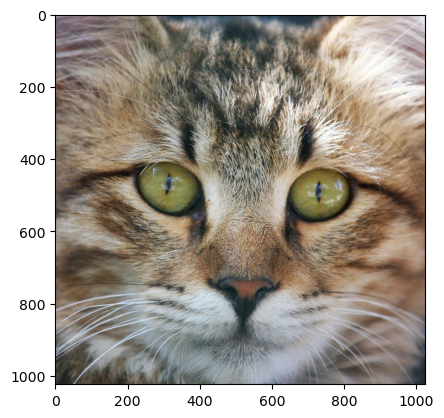

In [4]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os
import imageio.v2 as imageio
import numpy as np
import torch
lt.monkey_patch()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Download image, take a square crop from the center
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
plt.imshow(img)
plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        h, w, c = img.shape
        # Create a meshgrid of positions
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()  # shape (h*w, 2)
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0  # Normalize to [0, 1] range, shape (h*w, 3)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]


dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
xy, rgb = next(iter(loader))
xy, rgb


(tensor[64, 2] n=128 x∈[0.017, 0.997] μ=0.500 σ=0.302,
 tensor[64, 3] n=192 x∈[0.047, 0.914] μ=0.496 σ=0.180)

Epoch 100/1000, Loss: 0.3185180127620697, PSNR: 4.968659400939941
Epoch 200/1000, Loss: 0.08072204142808914, PSNR: 10.930079460144043
Epoch 300/1000, Loss: 0.020686546340584755, PSNR: 16.843120574951172
Epoch 400/1000, Loss: 0.005299609620124102, PSNR: 22.75756072998047
Epoch 500/1000, Loss: 0.0013513410231098533, PSNR: 28.692350387573242
Epoch 600/1000, Loss: 0.00034223473630845547, PSNR: 34.65675735473633
Epoch 700/1000, Loss: 8.598714339314029e-05, PSNR: 40.65566635131836
Epoch 800/1000, Loss: 2.14287774724653e-05, PSNR: 46.690025329589844
Epoch 900/1000, Loss: 5.300464636093238e-06, PSNR: 52.756858825683594
Epoch 1000/1000, Loss: 1.3028238754486665e-06, PSNR: 58.85114288330078


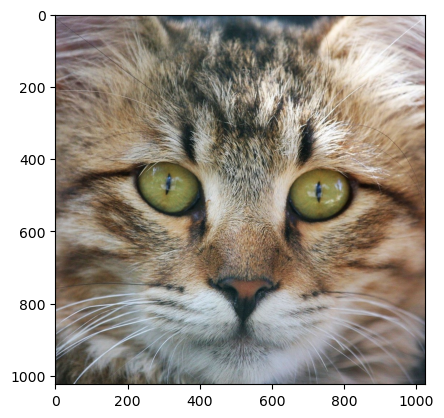

In [6]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Function to calculate Peak Signal-to-Noise Ratio (PSNR)
def psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    max_pixel = 1.0  # Assuming the pixel range of the image is [0, 1]
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

# Load the original image
original_image = img

# Preprocess the original image and convert it to a PyTorch tensor
preprocess = transforms.ToTensor()
original_tensor = preprocess(original_image).unsqueeze(0)

# Create a randomly initialized tensor for image reconstruction
reconstructed_tensor = torch.randn(original_tensor.size(), requires_grad=True)

# Define the Mean Squared Error (MSE) loss
criterion = torch.nn.MSELoss()

# Create an Adam optimizer for optimizing the reconstructed tensor
optimizer = optim.Adam([reconstructed_tensor], lr=0.01)

# Number of training epochs
num_epochs = 1000

# Lists to store losses and PSNR values
losses = []
psnr_values = []

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Calculate the loss between the reconstructed tensor and the original tensor
    loss = criterion(reconstructed_tensor, original_tensor)

    # Calculate PSNR and save it
    with torch.no_grad():
        psnr_value = psnr(original_tensor, reconstructed_tensor)
    psnr_values.append(psnr_value.item())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Save the loss value
    losses.append(loss.item())

    # Print the loss and PSNR
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr_value.item()}")

# Convert the reconstructed tensor to an image
reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze())
plt.imshow(reconstructed_image)
plt.show()

Obviously, the program outputs a perfect image with PSNR>50 quickyly.

## Approach 2

This approach is based on CNN. 

Epoch 10/1000, Loss: 0.019534440711140633, PSNR: 17.09199018508434
Epoch 20/1000, Loss: 0.0037757738027721643, PSNR: 24.229940310981096
Epoch 30/1000, Loss: 0.003736034967005253, PSNR: 24.275890676918472
Epoch 40/1000, Loss: 0.002296751830726862, PSNR: 26.38885928779093
Epoch 50/1000, Loss: 0.0018238177290186286, PSNR: 27.390185669049977
Epoch 60/1000, Loss: 0.0014294820139184594, PSNR: 28.44821304667731
Epoch 70/1000, Loss: 0.0009127960074692965, PSNR: 30.3962626817118
Epoch 80/1000, Loss: 0.0006766965962015092, PSNR: 31.69606008021659
Epoch 90/1000, Loss: 0.0005609492654912174, PSNR: 32.51076416308162
Epoch 100/1000, Loss: 0.00047987792640924454, PSNR: 33.188692264358586
Epoch 110/1000, Loss: 0.0004288741620257497, PSNR: 33.67670117499917
Epoch 120/1000, Loss: 0.000393059104681015, PSNR: 34.05542139429157
Epoch 130/1000, Loss: 0.00036228299723006785, PSNR: 34.409520479208446
Epoch 140/1000, Loss: 0.0003356861125212163, PSNR: 34.74066625329763
Epoch 150/1000, Loss: 0.00031165557447820

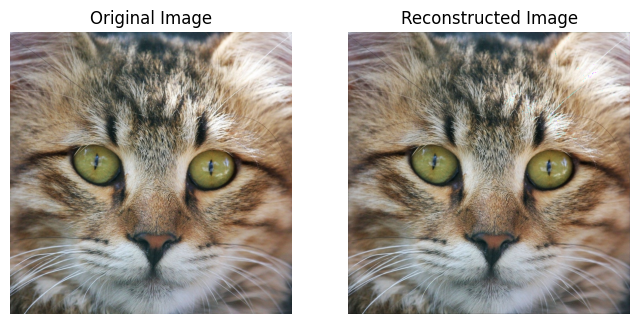

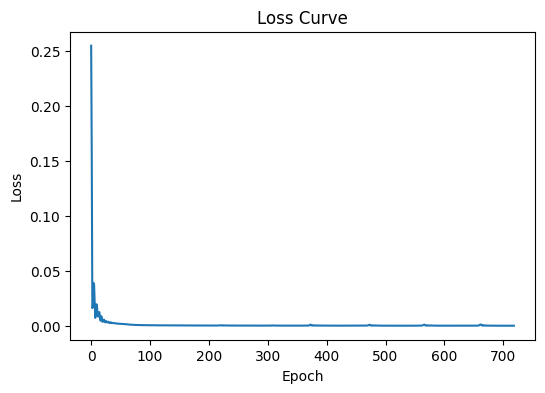

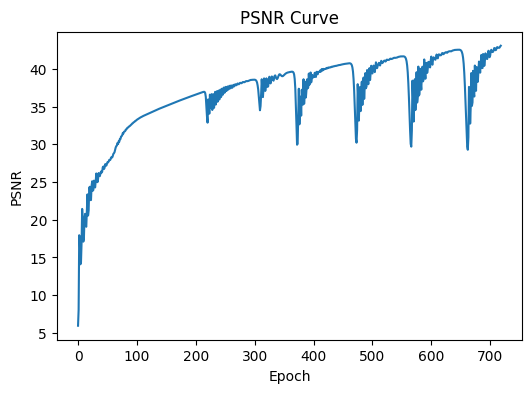

In [4]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import math

# Load the original image
preprocess = transforms.ToTensor()
original_tensor = preprocess(original_image).unsqueeze(0)

# Define the neural network model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.conv2(x)
        return x

# Initialize the neural network model and optimizer
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
num_epochs = 1000
losses = []
psnr_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass and compute the loss
    reconstructed_tensor = model(original_tensor)
    loss = criterion(reconstructed_tensor, original_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Save the loss value
    losses.append(loss.item())

    # Calculate PSNR
    mse = loss.item()
    psnr = 10 * math.log10(1 / mse)
    psnr_values.append(psnr)

    # Print the loss and PSNR
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr}")
    
    if psnr>43:
        break

# Convert the reconstructed tensor to an image
reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze())

# Display the original image and reconstructed image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis("off")

# Display the loss curve
plt.figure(figsize=(6, 4))
plt.title("Loss Curve")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Display the PSNR curve
plt.figure(figsize=(6, 4))
plt.title("PSNR Curve")
plt.plot(psnr_values)
plt.xlabel("Epoch")
plt.ylabel("PSNR")

plt.show()

As can see from the output, the PSNR easily exceeds 40. 

# Position Encoding
Then I considered position encoding. 

## NeRF-Style Encoding
Firstly, I defined the positional encoding as the NeRF paper where 
$$\gamma(x)=\left(\sin(2^0\pi x),\cos(2^0\pi x),\sin(2^1\pi x),\cos(2^1\pi x),\ldots,\sin(2^{L-1}\pi x),\cos(2^{L-1}\pi x)\right)$$
and $L=10$.

### 4-layer Neural Network
This approach includes a neural network which includes 4 layers containing 256, 256, 256, 128 channels respectively.

Iteration 0, Loss: 0.24106477200984955, PSNR: 6.1786627769470215
Iteration 100, Loss: 0.03223004564642906, PSNR: 14.917390823364258
Iteration 200, Loss: 0.019862452521920204, PSNR: 17.019670486450195
Iteration 300, Loss: 0.031217964366078377, PSNR: 15.055953979492188
Iteration 400, Loss: 0.019618986174464226, PSNR: 17.07323455810547
Iteration 500, Loss: 0.014981715939939022, PSNR: 18.244384765625
Iteration 600, Loss: 0.009826975874602795, PSNR: 20.0757999420166
Iteration 700, Loss: 0.012812480330467224, PSNR: 18.923667907714844
Iteration 800, Loss: 0.011765369214117527, PSNR: 19.2939453125
Iteration 900, Loss: 0.010166830383241177, PSNR: 19.928144454956055
Iteration 1000, Loss: 0.010354750789701939, PSNR: 19.848602294921875
Iteration 1100, Loss: 0.013060345314443111, PSNR: 18.8404541015625
Iteration 1200, Loss: 0.006460099946707487, PSNR: 21.897605895996094
Iteration 1300, Loss: 0.009143460541963577, PSNR: 20.388893127441406
Iteration 1400, Loss: 0.011581911705434322, PSNR: 19.36219787

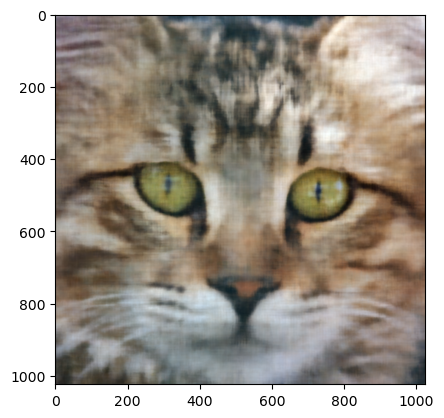

In [11]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os
import imageio.v2 as imageio
import numpy as np
import torch
lt.monkey_patch()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]

from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        h, w, c = img.shape
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]

dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

import torch
import torch.nn as nn

class PositionalEncodingNeRF(nn.Module): 
    def __init__(self, L=10):
        super(PositionalEncodingNeRF, self).__init__()
        self.L = L

    def forward(self, x):
        out = []
        for i in range(self.L):
            out.append(torch.sin((2. ** i) * x * np.pi))
            out.append(torch.cos((2. ** i) * x * np.pi))
        return torch.cat(out, dim=-1)

class Net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dims=[256, 256, 256, 128], pos_enc_params={}):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        L = pos_enc_params.get('L', 10)
        inp_dim *= 2 * L
        
        curr_dim = inp_dim
        for dim in hid_dims:
            self.layers.append(nn.Linear(curr_dim, dim))
            curr_dim = dim
        self.nonlin = nn.ReLU()
        self.out = nn.Linear(curr_dim, out_dim)
        self.positional_encoding = PositionalEncodingNeRF(L)

    def forward(self, x):
        z = self.positional_encoding(x)
        for layer in self.layers:
            z = self.nonlin(layer(z))
        return self.out(z)

import torch.nn.functional as F
from torch.optim import Adam

def compute_psnr(gtr, out):
    mse = F.mse_loss(gtr, out)
    psnr = -10 * torch.log10(mse)
    return psnr.item()

def compute_loss(out, y):
    return F.mse_loss(out, y)

net = Net(2, 3, hid_dims=[256, 256, 256, 128], pos_enc_params={'L': 10}) # 4 layers here
opt = Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)

data_iter = iter(loader)
for iteration in range(100000):
    try:
        x, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        x, y = next(data_iter)

    opt.zero_grad()
    out = net(x)
    loss = compute_loss(out, y)
    loss.backward()
    opt.step()
    scheduler.step()

    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {compute_psnr(y, out)}")
    if compute_psnr(y, out)>28: 
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {compute_psnr(y, out)}")
        break

def create_image(resolution):
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    positions = np.stack((xv, yv), axis=-1)
    x = torch.from_numpy(positions.reshape(-1, 2)).float()
    rgb = net(x).reshape(resolution, resolution, 3)
    rgb = torch.clamp(rgb, 0, 1)
    return rgb.detach().cpu().numpy()

out_img = create_image(1024)
plt.imshow(out_img)

And for the second question, I considered two approaches.

Firstly, I modified the architecture by adding symmetric features when encoding. x was changed to |x-0.5| in the positional encoding so that the symmetric two points result in the same result, enforcing a symmetric output eventually.

Iteration 0, Loss: 0.3226793706417084, PSNR: 4.912287712097168
Iteration 100, Loss: 0.04341380298137665, PSNR: 13.623722076416016
Iteration 200, Loss: 0.02788688987493515, PSNR: 15.545998573303223
Iteration 300, Loss: 0.025801265612244606, PSNR: 15.883589744567871
Iteration 400, Loss: 0.02712390013039112, PSNR: 15.666479110717773
Iteration 500, Loss: 0.018061382696032524, PSNR: 17.432491302490234
Iteration 600, Loss: 0.03264826163649559, PSNR: 14.861398696899414
Iteration 700, Loss: 0.022630395367741585, PSNR: 16.453079223632812
Iteration 800, Loss: 0.02737857960164547, PSNR: 15.625890731811523
Iteration 900, Loss: 0.03145555034279823, PSNR: 15.023027420043945
Iteration 1000, Loss: 0.029950475320219994, PSNR: 15.235962867736816
Iteration 1100, Loss: 0.024693230167031288, PSNR: 16.074220657348633
Iteration 1200, Loss: 0.028042053803801537, PSNR: 15.521902084350586
Iteration 1300, Loss: 0.033869486302137375, PSNR: 14.701913833618164
Iteration 1400, Loss: 0.025651976466178894, PSNR: 15.90

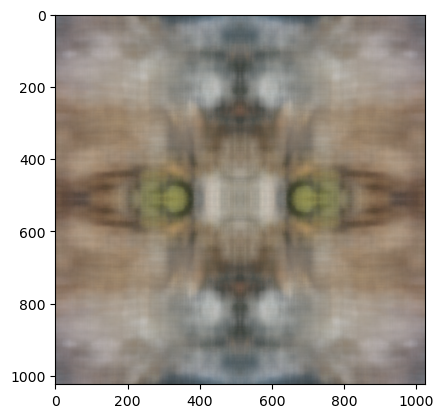

In [15]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os
import imageio.v2 as imageio
import numpy as np
import torch
lt.monkey_patch()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]

from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        h, w, c = img.shape
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]

dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

import torch
import torch.nn as nn

class PositionalEncodingNeRF(nn.Module): 
    def __init__(self, L=10):
        super(PositionalEncodingNeRF, self).__init__()
        self.L = L

    def forward(self, x):
        x = abs(x - 0.5) # Modified here
        out = []
        for i in range(self.L):
            out.append(torch.sin((2. ** i) * x * np.pi))
            out.append(torch.cos((2. ** i) * x * np.pi))
        return torch.cat(out, dim=-1)

class Net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dims=[256, 256, 256, 128], pos_enc_params={}):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        L = pos_enc_params.get('L', 10)
        inp_dim *= 2 * L
        
        curr_dim = inp_dim
        for dim in hid_dims:
            self.layers.append(nn.Linear(curr_dim, dim))
            curr_dim = dim
        self.nonlin = nn.ReLU()
        self.out = nn.Linear(curr_dim, out_dim)
        self.positional_encoding = PositionalEncodingNeRF(L)

    def forward(self, x):
        z = self.positional_encoding(x)
        for layer in self.layers:
            z = self.nonlin(layer(z))
        return self.out(z)

import torch.nn.functional as F
from torch.optim import Adam

def compute_psnr(gtr, out):
    mse = F.mse_loss(gtr, out)
    psnr = -10 * torch.log10(mse)
    return psnr.item()

def compute_loss(out, y):
    return F.mse_loss(out, y)

net = Net(2, 3, hid_dims=[256, 256, 256, 128], pos_enc_params={'L': 10}) # 4 layers here
opt = Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)

data_iter = iter(loader)
for iteration in range(100000):
    try:
        x, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        x, y = next(data_iter)

    opt.zero_grad()
    out = net(x)
    loss = compute_loss(out, y)
    loss.backward()
    opt.step()
    scheduler.step()

    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {compute_psnr(y, out)}")
    if compute_psnr(y, out)>19: 
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {compute_psnr(y, out)}")
        break

def create_image(resolution):
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    positions = np.stack((xv, yv), axis=-1)
    x = torch.from_numpy(positions.reshape(-1, 2)).float()
    rgb = net(x).reshape(resolution, resolution, 3)
    rgb = torch.clamp(rgb, 0, 1)
    return rgb.detach().cpu().numpy()

out_img = create_image(1024)
plt.imshow(out_img)

As for the second approach, I added one more symmetric sample when constructing the dataset.

Iteration 0, Loss: 0.26664039492607117, PSNR: 5.7407402992248535
Iteration 100, Loss: 0.03028861992061138, PSNR: 15.18720531463623
Iteration 200, Loss: 0.0424443744122982, PSNR: 13.72179889678955
Iteration 300, Loss: 0.029634570702910423, PSNR: 15.282012939453125
Iteration 400, Loss: 0.03094039112329483, PSNR: 15.094741821289062
Iteration 500, Loss: 0.02872658520936966, PSNR: 15.417160034179688
Iteration 600, Loss: 0.02611507661640644, PSNR: 15.831087112426758
Iteration 700, Loss: 0.023774495348334312, PSNR: 16.238887786865234
Iteration 800, Loss: 0.025937572121620178, PSNR: 15.860706329345703
Iteration 900, Loss: 0.0276307612657547, PSNR: 15.586071014404297
Iteration 1000, Loss: 0.022550784051418304, PSNR: 16.4683837890625
Iteration 1100, Loss: 0.027397945523262024, PSNR: 15.622819900512695
Iteration 1200, Loss: 0.022861748933792114, PSNR: 16.408905029296875
Iteration 1300, Loss: 0.023940926417708397, PSNR: 16.208589553833008
Iteration 1400, Loss: 0.023721136152744293, PSNR: 16.248643

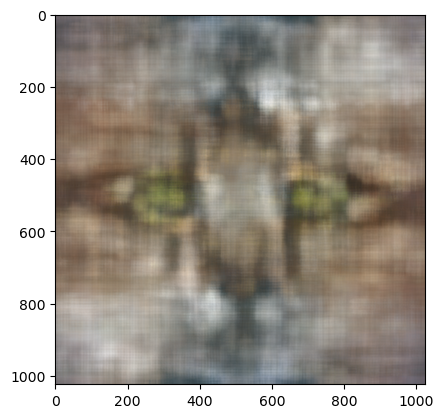

In [17]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os
import imageio.v2 as imageio
import numpy as np
import torch
lt.monkey_patch()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]

from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        h, w, c = img.shape
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0
        
        # Modified here
        x = np.linspace(1, 0, w)
        y = np.linspace(1, 0, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)
        
        self.X = torch.cat((self.X, torch.from_numpy(positions.reshape(-1, 2)).float()), dim=0)
        self.Y = torch.cat((self.Y, torch.from_numpy(img.reshape(-1, c)).float() / 255.0), dim=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]

dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

import torch
import torch.nn as nn

class PositionalEncodingNeRF(nn.Module): 
    def __init__(self, L=10):
        super(PositionalEncodingNeRF, self).__init__()
        self.L = L

    def forward(self, x):
        out = []
        for i in range(self.L):
            out.append(torch.sin((2. ** i) * x * np.pi))
            out.append(torch.cos((2. ** i) * x * np.pi))
        return torch.cat(out, dim=-1)

class Net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dims=[256, 256, 256, 128], pos_enc_params={}):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        L = pos_enc_params.get('L', 10)
        inp_dim *= 2 * L
        
        curr_dim = inp_dim
        for dim in hid_dims:
            self.layers.append(nn.Linear(curr_dim, dim))
            curr_dim = dim
        self.nonlin = nn.ReLU()
        self.out = nn.Linear(curr_dim, out_dim)
        self.positional_encoding = PositionalEncodingNeRF(L)

    def forward(self, x):
        z = self.positional_encoding(x)
        for layer in self.layers:
            z = self.nonlin(layer(z))
        return self.out(z)

import torch.nn.functional as F
from torch.optim import Adam

def compute_psnr(gtr, out):
    mse = F.mse_loss(gtr, out)
    psnr = -10 * torch.log10(mse)
    return psnr.item()

def compute_loss(out, y):
    return F.mse_loss(out, y)

net = Net(2, 3, hid_dims=[256, 256, 256, 128], pos_enc_params={'L': 10}) # 4 layers here
opt = Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)

data_iter = iter(loader)
for iteration in range(100000):
    try:
        x, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        x, y = next(data_iter)

    opt.zero_grad()
    out = net(x)
    loss = compute_loss(out, y)
    loss.backward()
    opt.step()
    scheduler.step()

    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {compute_psnr(y, out)}")
    if compute_psnr(y, out)>19: 
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {compute_psnr(y, out)}")
        break

def create_image(resolution):
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    positions = np.stack((xv, yv), axis=-1)
    x = torch.from_numpy(positions.reshape(-1, 2)).float()
    rgb = net(x).reshape(resolution, resolution, 3)
    rgb = torch.clamp(rgb, 0, 1)
    return rgb.detach().cpu().numpy()

out_img = create_image(1024)
plt.imshow(out_img)

For this network structure, it is noticeable that the PSNR was quite low. So I further thought about creating the same network as the NeRF paper.

### 9-layer Neural Network
The network has the structure as from the NeRF paper in Appendix A, where

1. Input positional encoding $\gamma(x)$ of size 60 (2 coordinates * 30 frequencies for each). 
2. 8 fully-connected layers with ReLU activations, each with 256 channels.
3. A skip connection that concatenates the input positional encoding to the fifth layer's activations.
4. An output layer that gives a volume density (using a ReLU) and a 256-dimensional feature vector. 
5. Concatenation of this feature vector with the positional encoding of the input viewing direction $\gamma(d)$ of size 24 (1 coordinate * 12 frequencies for each).
6. An additional fully-connected ReLU layer with 128 channels. 
7. Afinal layer with a sigmoid activation that outputs the RGB radiance.

The difference is that I skipped the volumn density loss in the NeRF paper.

Iteration 0, Loss: 0.03660859167575836, PSNR: 14.36417007446289
Iteration 100, Loss: 0.02927987463772297, PSNR: 15.334308624267578
Iteration 200, Loss: 0.01663680374622345, PSNR: 17.7893009185791
Iteration 300, Loss: 0.02166275680065155, PSNR: 16.64286231994629
Iteration 400, Loss: 0.013095460832118988, PSNR: 18.828792572021484
Iteration 500, Loss: 0.014430028386414051, PSNR: 18.40732765197754
Iteration 600, Loss: 0.009588501416146755, PSNR: 20.182493209838867
Iteration 700, Loss: 0.01276060938835144, PSNR: 18.941286087036133
Iteration 800, Loss: 0.010936297476291656, PSNR: 19.611297607421875
Iteration 900, Loss: 0.011400277726352215, PSNR: 19.430845260620117
Iteration 1000, Loss: 0.010705962777137756, PSNR: 19.70374298095703
Iteration 1100, Loss: 0.008467764593660831, PSNR: 20.722312927246094
Iteration 1200, Loss: 0.007270687725394964, PSNR: 21.38424301147461
Iteration 1300, Loss: 0.006796456873416901, PSNR: 21.677173614501953
Iteration 1400, Loss: 0.007398890797048807, PSNR: 21.30833

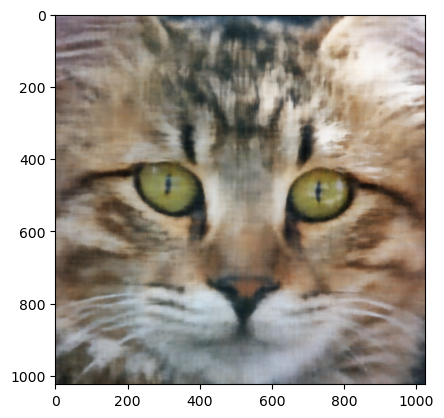

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import imageio.v2 as imageio
import os
import copy

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

image_url = "https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg"
img = imageio.imread(image_url)[..., :3]


# Positional Encoding (NeRF-style)
class PositionalEncodingNeRF(nn.Module):
    def __init__(self, L=10):
        super(PositionalEncodingNeRF, self).__init__()
        self.L = L

    def forward(self, x):
        out = []
        for i in range(self.L):
            out.append(torch.sin((2.0**i) * x * np.pi))
            out.append(torch.cos((2.0**i) * x * np.pi))
        return torch.cat(out, dim=-1)


# Define the NeRF-style network architecture with skip connections
class NeRFNetwork(nn.Module):
    def __init__(
        self,
        inp_dim,
        out_dim,
        hid_dims=[256, 256, 256, 256, 256, 256, 256, 256, 256],
        pos_enc_L=10,
        dir_enc_L=4,
    ):
        super(NeRFNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.pos_enc = PositionalEncodingNeRF(L=pos_enc_L)
        self.dir_enc = PositionalEncodingNeRF(L=dir_enc_L)

        # input dimensionality is 2 for (x, y), multiplied by 2 for sin and cos, and by L for number of frequencies
        encoded_dim = inp_dim * 2 * pos_enc_L
        self.fc_in = nn.Linear(encoded_dim, hid_dims[0])

        # hidden layers with skip connection to the fifth layer
        for i in range(len(hid_dims) - 2):
            if i == 4:  # skip connection to the 5th layer
                self.layers.append(
                    nn.Linear(hid_dims[i] + encoded_dim, hid_dims[i + 1])
                )
            else:
                self.layers.append(nn.Linear(hid_dims[i], hid_dims[i + 1]))

        # The feature vector is the second to last layer's output
        self.fc_feature = nn.Linear(hid_dims[-2], hid_dims[-1])

        # Directional encoding for the view direction d
        dir_encoded_dim = 3 * 2 * dir_enc_L
        self.fc_dir_in = nn.Linear(hid_dims[-1] + dir_encoded_dim, 128)

        # Output layer for RGB color
        self.fc_dir_out = nn.Linear(128, out_dim)  # * 2 for concatenating feature vector and dir_enc

    def forward(self, x, d):
        # Position encoding
        encoded_x = self.pos_enc(x)
        z = F.relu(self.fc_in(encoded_x))
        for i, layer in enumerate(self.layers):
            if i == 4:  # This is the skip-connected layer
                z = torch.cat([encoded_x, z], dim=1)
            z = F.relu(layer(z))

        # Feature vector
        feature_vector = self.fc_feature(z)

        # Direction encoding
        encoded_d = self.dir_enc(d)

        # Concatenate feature vector with directionally encoded input
        combined = torch.cat([feature_vector, encoded_d], dim=1)

        # Output layer for RGB color with sigmoid activation
        z = F.relu(self.fc_dir_in(combined))

        rgb = F.sigmoid(self.fc_dir_out(z))

        return rgb


# Custom dataset to feed into DataLoader
class CustomImageDataset(Dataset):
    def __init__(self, img, dir_enc_L=4):
        h, w, c = img.shape
        # Create a meshgrid of positions
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)
        directions = np.random.normal(
            size=(h, w, 3)
        )  # Placeholder for directions, replace with actual directions if available

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()  # shape (h*w, 2)
        self.D = torch.from_numpy(directions.reshape(-1, 3)).float()
        self.Y = (torch.from_numpy(img.reshape(-1, c)).float() / 255.0)  # Normalize to [0, 1] range, shape (h*w, 3)

        # The following codes are for the second question, and I made them comment to run the first question
        # x = np.linspace(1, 0, w)
        # y = np.linspace(1, 0, h)
        # xv, yv = np.meshgrid(x, y)
        # positions = np.stack((xv, yv), axis=-1)
        # directions = np.random.normal(size=(h, w, 3))

        # self.X = torch.cat(
        #     [self.X, torch.from_numpy(positions.reshape(-1, 2)).float()],
        #     dim=0
        # )
        # self.D = torch.cat(
        #     [self.D, torch.from_numpy(directions.reshape(-1, 3)).float()],
        #     dim=0
        # )
        # self.Y = torch.cat(
        #     [self.Y, torch.from_numpy(img.reshape(-1, c)).float() / 255.0],
        #     dim = 0
        # )

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.D[idx, :], self.Y[idx, :]


def compute_psnr(gtr, out):
    mse = F.mse_loss(gtr, out)
    psnr = -10 * torch.log10(mse)
    return psnr.item()


def compute_loss(out, y):
    return F.mse_loss(out, y)


dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the network
net = NeRFNetwork(
    inp_dim=2,
    out_dim=3,
    hid_dims=[256, 256, 256, 256, 256, 256, 256, 256],
    pos_enc_L=10,
    dir_enc_L=4,
)
opt = Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)

# Training loop
data_iter = iter(loader)
max_psnr = 0
best_model = None
for iteration in range(30000):  # Train for 30000 iterations
    try:
        x, d, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        x, d, y = next(data_iter)

    opt.zero_grad()
    out_rgb = net(x, d)
    loss_rgb = F.mse_loss(out_rgb, y)
    loss_rgb.backward()
    opt.step()
    scheduler.step()

    if -10 * torch.log10(loss_rgb) > max_psnr:
        max_psnr = -10 * torch.log10(loss_rgb)
        best_model = copy.deepcopy(net)

    if iteration % 100 == 0:
        print(
            f"Iteration {iteration}, Loss: {loss_rgb.item()}, PSNR: {-10 * torch.log10(loss_rgb)}"
        )
    if -10 * torch.log10(loss_rgb) > 30:
        print(
            f"Iteration {iteration}, Loss: {loss_rgb.item()}, PSNR: {-10 * torch.log10(loss_rgb)}"
        )
        break

print(f"Max PSNR: {max_psnr}")

def create_image(resolution, net):
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    positions = np.stack((xv, yv), axis=-1)

    # Generate a direction tensor, similar to the one used in the training stage
    directions = np.random.normal(size=(resolution, resolution, 3))

    x = torch.from_numpy(positions.reshape(-1, 2)).float()
    d = torch.from_numpy(directions.reshape(-1, 3)).float()  # New direction tensor

    out_rgb = best_model(x, d)
    rgb = out_rgb.reshape(resolution, resolution, 3)  # Used output from network

    rgb = torch.clamp(rgb, 0, 1)
    return rgb.detach().cpu().numpy()


out_img = create_image(1024, net)
plt.imshow(out_img)
plt.show()

Similar to the previous architecture, the PSNR hardly exceed 30 and the output image is blurry.

Thus, for further exploration, other architectures may be considered.

### Another Encoding Approach

I further considered an approach without using the same encoding method as the NeRF paper, which results in a good output. 

Epoch 100/30000, Loss: 18760.140625
Epoch 200/30000, Loss: 18506.388671875
Epoch 300/30000, Loss: 18255.529296875
Epoch 400/30000, Loss: 18007.509765625
Epoch 500/30000, Loss: 17762.275390625
Epoch 600/30000, Loss: 17519.783203125
Epoch 700/30000, Loss: 17279.974609375
Epoch 800/30000, Loss: 17042.810546875
Epoch 900/30000, Loss: 16808.244140625
Epoch 1000/30000, Loss: 16576.23046875
Epoch 1100/30000, Loss: 16346.7265625
Epoch 1200/30000, Loss: 16119.69140625
Epoch 1300/30000, Loss: 15895.0869140625
Epoch 1400/30000, Loss: 15672.8779296875
Epoch 1500/30000, Loss: 15453.0205078125
Epoch 1600/30000, Loss: 15235.48828125
Epoch 1700/30000, Loss: 15020.2421875
Epoch 1800/30000, Loss: 14807.2509765625
Epoch 1900/30000, Loss: 14596.4853515625
Epoch 2000/30000, Loss: 14387.9140625
Epoch 2100/30000, Loss: 14181.5087890625
Epoch 2200/30000, Loss: 13977.2421875
Epoch 2300/30000, Loss: 13775.0859375
Epoch 2400/30000, Loss: 13575.01953125
Epoch 2500/30000, Loss: 13377.015625
Epoch 2600/30000, Loss:

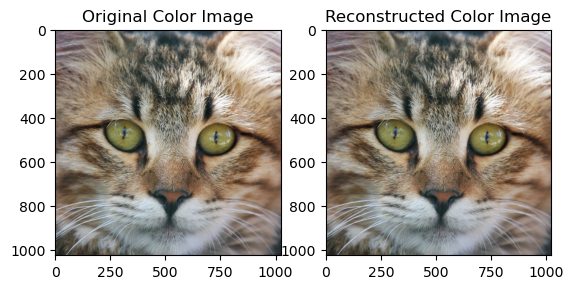

In [24]:
import numpy as np
import scipy.optimize as opt
from skimage import io
from skimage.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim

# Read the original color image
original_image = img

# Get the dimensions of the original image
image_height, image_width, num_channels = original_image.shape

# Define position encoding
def position_encoding(height, width):
    position_enc = np.zeros((height, width, num_channels))
    for i in range(height):
        for j in range(width):
            for c in range(num_channels):
                position_enc[i, j, c] = (i / height) - (j / width)
    return position_enc

# Define pixel-level difference function (mean squared error)
def pixel_difference(image, target):
    return mean_squared_error(target, image)

# Define a neural network model to adjust pixel values
class ReconstructionModel(nn.Module):
    def __init__(self, image_height, image_width, num_channels):
        super(ReconstructionModel, self).__init__()
        self.position_enc = torch.tensor(position_encoding(image_height, image_width), dtype=torch.float32)
        self.reconstructed_image = nn.Parameter(torch.randn(1, image_height, image_width, num_channels))

    def forward(self):
        return self.position_enc + self.reconstructed_image

# Initialize the neural network model
model = ReconstructionModel(image_height, image_width, num_channels)

# Define the target image (original image)
target_image = torch.tensor(original_image, dtype=torch.float32).unsqueeze(0)

# Define the pixel-level difference function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Iteratively optimize pixel values
num_epochs = 30000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model()
    loss = criterion(outputs, target_image)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Get the optimized reconstructed image
reconstructed_image = model().detach().numpy()[0]

# Print the pixel-level difference
mse = pixel_difference(original_image, reconstructed_image)
# Save the reconstructed image
io.imsave('reconstructed_color_image.jpg', reconstructed_image.astype(np.uint8))

# If visualization is needed
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Color Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.astype(np.uint8))
plt.title('Reconstructed Color Image')

plt.show()

The reconstructed figure is perfect.

Then I considered one approach to take enforce symmetric. A weighted symmetric loss is added when training.

Epoch 100/30000, Loss: 18759.1796875
Epoch 200/30000, Loss: 18505.4296875
Epoch 300/30000, Loss: 18254.56640625
Epoch 400/30000, Loss: 18006.544921875
Epoch 500/30000, Loss: 17761.30859375
Epoch 600/30000, Loss: 17518.8125
Epoch 700/30000, Loss: 17279.00390625
Epoch 800/30000, Loss: 17041.83984375
Epoch 900/30000, Loss: 16807.271484375
Epoch 1000/30000, Loss: 16575.255859375
Epoch 1100/30000, Loss: 16345.751953125
Epoch 1200/30000, Loss: 16118.7197265625
Epoch 1300/30000, Loss: 15894.1201171875
Epoch 1400/30000, Loss: 15671.912109375
Epoch 1500/30000, Loss: 15452.064453125
Epoch 1600/30000, Loss: 15234.5390625
Epoch 1700/30000, Loss: 15019.30078125
Epoch 1800/30000, Loss: 14806.32421875
Epoch 1900/30000, Loss: 14595.5712890625
Epoch 2000/30000, Loss: 14387.0166015625
Epoch 2100/30000, Loss: 14180.6318359375
Epoch 2200/30000, Loss: 13976.38671875
Epoch 2300/30000, Loss: 13774.2587890625
Epoch 2400/30000, Loss: 13574.224609375
Epoch 2500/30000, Loss: 13376.2529296875
Epoch 2600/30000, Lo

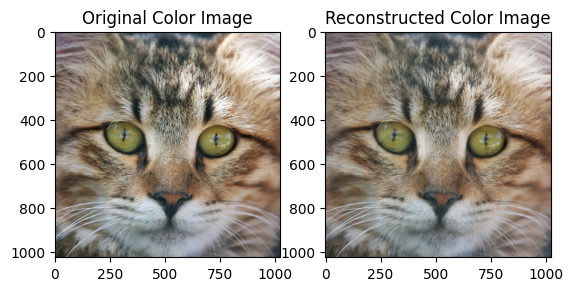

In [100]:
import numpy as np
import scipy.optimize as opt
from skimage import io
from skimage.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim

# Read the original color image
original_image = img

# Get the dimensions of the original image
image_height, image_width, num_channels = original_image.shape

# Define position encoding
def position_encoding(height, width):
    position_enc = np.zeros((height, width, num_channels))
    for i in range(height):
        for j in range(width):
            for c in range(num_channels):
                position_enc[i, j, c] = (i / height) - (j / width)
    return position_enc

# Define pixel-level difference function (mean squared error)
def pixel_difference(image, target):
    return mean_squared_error(target, image)

# Define a neural network model to adjust pixel values
class ReconstructionModel(nn.Module):
    def __init__(self, image_height, image_width, num_channels):
        super(ReconstructionModel, self).__init__()
        self.position_enc = torch.tensor(position_encoding(image_height, image_width), dtype=torch.float32)
        self.reconstructed_image = nn.Parameter(torch.randn(1, image_height, image_width, num_channels))

    def forward(self):
        return self.position_enc + self.reconstructed_image

# Initialize the neural network model
model = ReconstructionModel(image_height, image_width, num_channels)

# Define the target image (original image)
target_image = torch.tensor(original_image, dtype=torch.float32).unsqueeze(0)

# Define the pixel-level difference function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Iteratively optimize pixel values
num_epochs = 30000

# Custom symmetry loss function
def symmetry_loss(image):
    height, width = image.shape[:2]  # Only unpack height and width
    left_half = image[:, :width // 2]
    right_half = torch.flip(image[:, width // 2:], dims=[1])  # Flip the right half

    # Calculate the mean squared error between the left and right halves
    sym_loss = torch.mean((left_half - right_half) ** 2)
    return sym_loss

# Add symmetry loss to the overall loss
symmetry_weight = 0.1  # Adjust the weight as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model()
    loss = criterion(outputs, target_image) + symmetry_weight * symmetry_loss(outputs)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")



# Get the optimized reconstructed image
reconstructed_image = model().detach().numpy()[0]

# Print the pixel-level difference
mse = pixel_difference(original_image, reconstructed_image)
# Save the reconstructed image
io.imsave('reconstructed_color_image.jpg', reconstructed_image.astype(np.uint8))

# If visualization is needed
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Color Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.astype(np.uint8))
plt.title('Reconstructed Color Image')

plt.show()


The loss difference in this program from the previous one indicates that symmetry is considered. A higher symmetry weight will lead to more significant changes.

# Conclusion

In conclusion, a good output could be generated by position encoding and other approaches like CNN. However, I haven't gotten a perfect output with the encoding method and even with the net architecture of NeRF paper. 